In [1]:
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import pickle

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error


import holidays
from prophet import Prophet

/Users/luca/Desktop/ThesisKernelMethods/summercode/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [3]:
# load data
df_train=pd.read_csv("/Users/luca/Desktop/GEFCom2014 Data/Load/L-train.csv")

df_train=df_train[["DS","LOAD"]]
# renaming necessary for prophet to work
df_train.columns=["ds", "y"]

df_test=pd.read_csv(f"/Users/luca/Desktop/GEFCom2014 Data/Load/Task 1/L1-test_clean.csv")

X_test=df_test[["DAY",  "MONTH",  "HOUR",  "DAY_OF_WEEK",  "IS_HOLIDAY",  "w_avg"]]
y_test=df_test["LOAD"]

In [4]:
# init vanilla prophet
prophet=Prophet()
prophet.fit(df_train)

15:26:02 - cmdstanpy - INFO - Chain [1] start processing
15:26:11 - cmdstanpy - INFO - Chain [1] done processing


In [5]:
# create df for target predictions
future = prophet.make_future_dataframe(periods=len(y_test), freq='H')
future

,ds
0,2005-01-01 01:00:00
1,2005-01-01 02:00:00
2,2005-01-01 03:00:00
3,2005-01-01 04:00:00
4,2005-01-01 05:00:00
...,...
51115,2010-10-31 20:00:00
51116,2010-10-31 21:00:00
51117,2010-10-31 22:00:00
51118,2010-10-31 23:00:00


In [6]:
# predict
forecast = prophet.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
51115,2010-10-31 20:00:00,169.905437,127.296833,215.226577
51116,2010-10-31 21:00:00,166.452226,126.822481,205.867307
51117,2010-10-31 22:00:00,157.305944,115.710730,199.383879
51118,2010-10-31 23:00:00,144.593489,108.964257,191.686545
51119,2010-11-01 00:00:00,131.378204,89.003655,172.338504


In [7]:
y_hat=forecast.tail(len(y_test))["yhat"].values

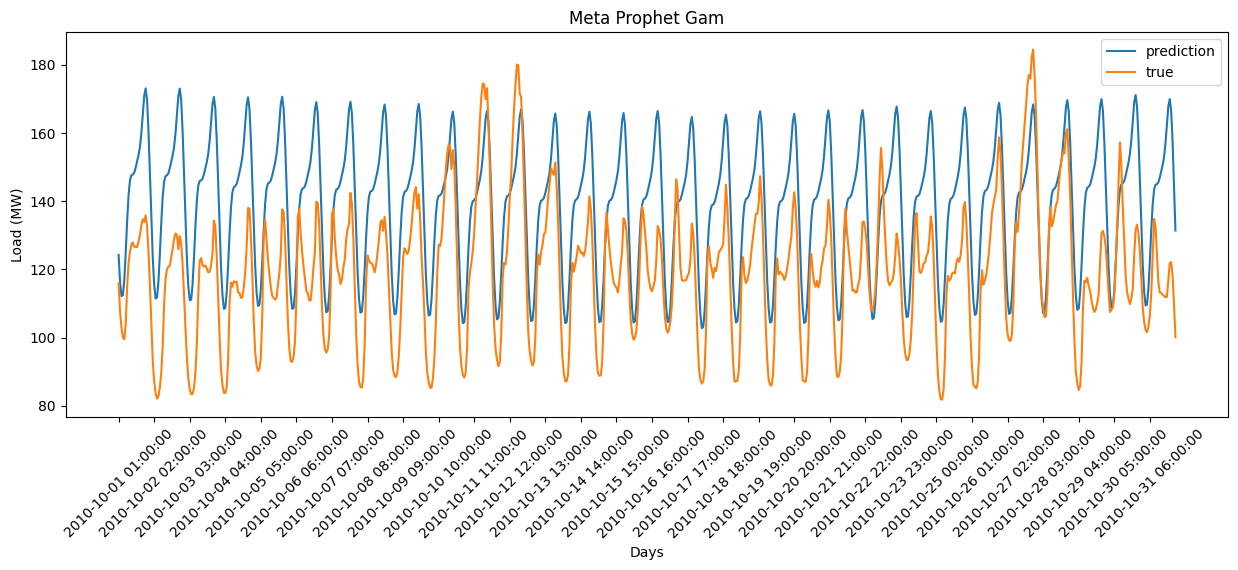

In [8]:
plt.figure(figsize=(15,5))
plt.plot(y_hat, label="prediction")
plt.plot(df_test["DS"],y_test, label="true")

plt.xticks(np.arange(0,len(y_test)+1,25),rotation=45)

plt.xlabel("Days")
plt.ylabel("Load (MW)")
plt.title("Meta Prophet Gam")
plt.legend()
plt.show()



In [8]:
# error measure
np.sqrt(mean_squared_error(y_test, y_hat))

23.961848164686245

In [592]:
# info we have from forecast
print("columns output: ", forecast.columns)

columns output:  Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'daily', 'daily_lower', 'daily_upper', 'weekly', 'weekly_lower',
       'weekly_upper', 'yearly', 'yearly_lower', 'yearly_upper',
       'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')


Additional plots

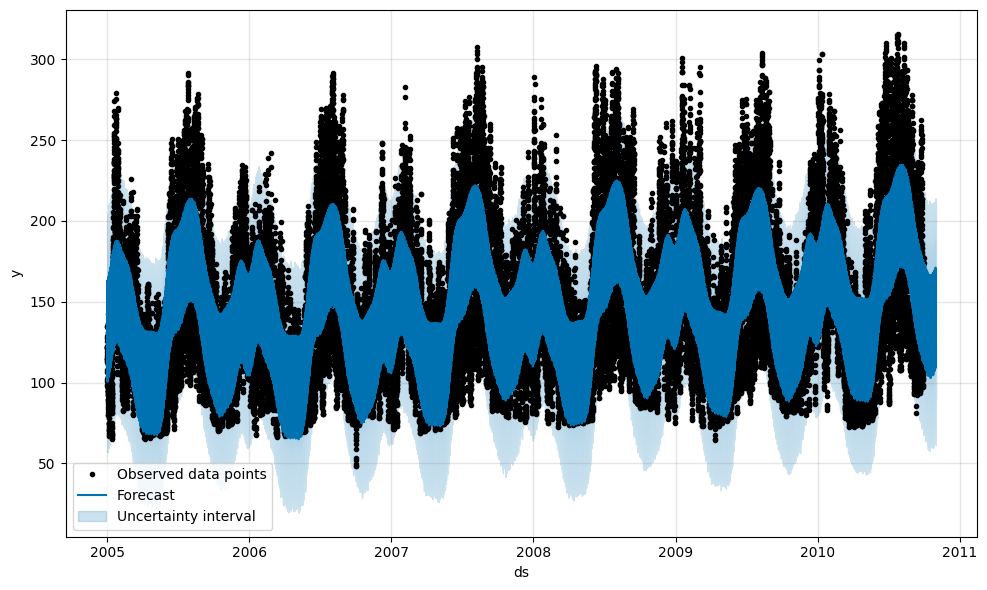

In [601]:
# This plot shows how the model behaves in the insample prediction

prophet.plot(forecast)
plt.legend()
plt.show()

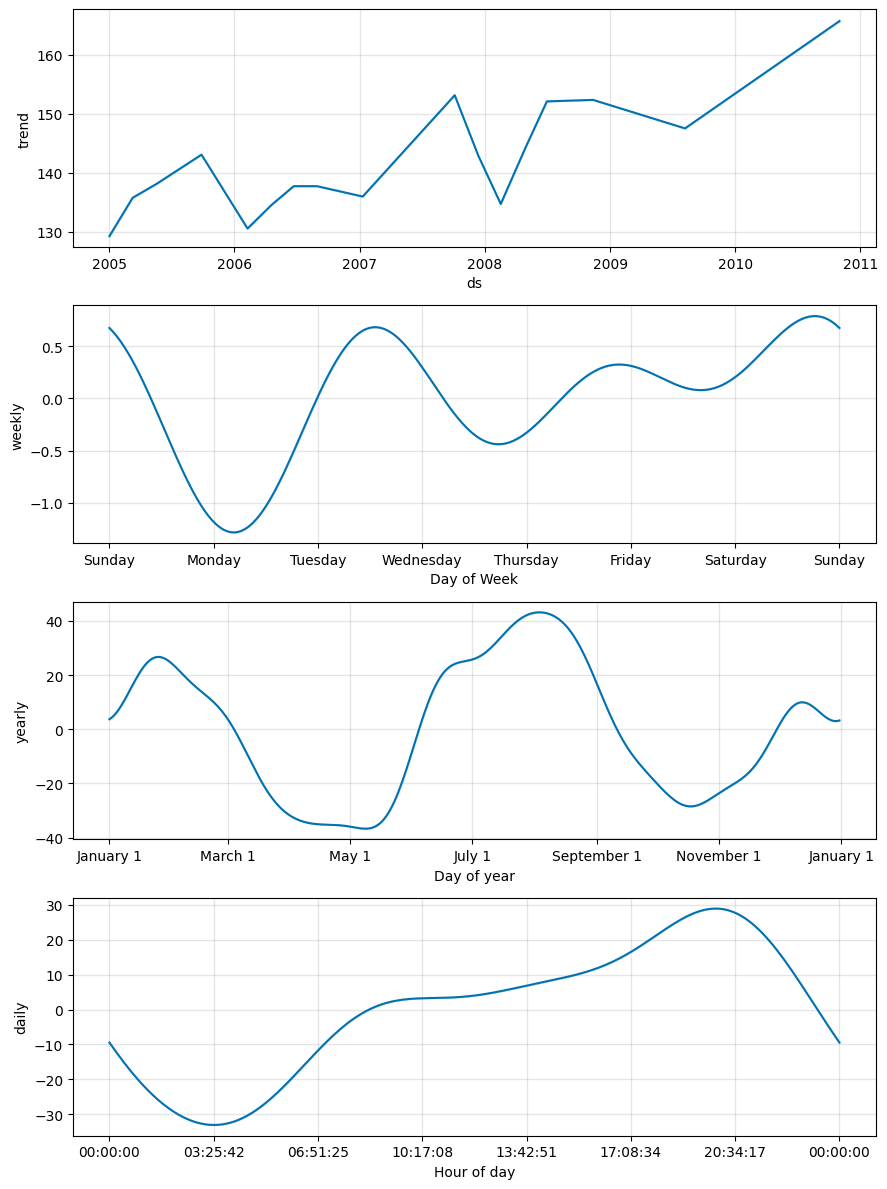

In [604]:
# this data explains the learned seasonalities

prophet.plot_components(forecast)
plt.show()

Adding regressors to improve it

In [37]:
# load data
df_train=pd.read_csv("/Users/luca/Desktop/GEFCom2014 Data/Load/L-train.csv")
y_train=df_train["LOAD"]
X_train=df_train[["DAY","MONTH","HOUR","DAY_OF_WEEK","IS_HOLIDAY","w_avg"]]

# rename for prophet API
df_train=df_train.rename(columns={'DS': 'ds'})
df_train=df_train.rename(columns={'LOAD': 'y'})

# load test
df_test=pd.read_csv(f"/Users/luca/Desktop/GEFCom2014 Data/Load/Task 1/L1-test_clean.csv")

X_test=df_test[["DAY",  "MONTH",  "HOUR",  "DAY_OF_WEEK",  "IS_HOLIDAY",  "w_avg"]]
y_test=df_test["LOAD"]

# log transform the target variable
# and add the power of temperature as regressor
df_train["y"]=np.log(df_train["y"])
df_train["w_avg2"]=df_train["w_avg"]**2
df_test["w_avg2"]=df_test["w_avg"]**2

In [39]:
# init model
prophet=Prophet(changepoint_prior_scale=0.5)
# add holidays
prophet.add_country_holidays(country_name='US')
# add regressors
prophet.add_regressor('w_avg')
prophet.add_regressor('w_avg2')

# fit model
# prophet.fit(df_train[["ds","y","w_avg"]])
prophet.fit(df_train[["ds","y","w_avg","w_avg2"]])

15:33:29 - cmdstanpy - INFO - Chain [1] start processing
15:33:45 - cmdstanpy - INFO - Chain [1] done processing


In [40]:
# create targets for prediction
future = prophet.make_future_dataframe(periods=len(y_test), freq='H')
future.tail(10)

,ds
51110,2010-10-31 15:00:00
51111,2010-10-31 16:00:00
51112,2010-10-31 17:00:00
51113,2010-10-31 18:00:00
51114,2010-10-31 19:00:00
51115,2010-10-31 20:00:00
51116,2010-10-31 21:00:00
51117,2010-10-31 22:00:00
51118,2010-10-31 23:00:00
51119,2010-11-01 00:00:00


In [41]:
# add regressors to the future df
# regressors=pd.concat([df_train[["w_avg"]],df_test[["w_avg"]]])
regressors=pd.concat([df_train[["w_avg","w_avg2"]],df_test[["w_avg","w_avg2"]]])

future["w_avg"]=regressors["w_avg"].values
future["w_avg2"]=regressors["w_avg2"].values

# see future df
future

,ds,w_avg,w_avg2
0,2005-01-01 01:00:00,46.20,2134.4400
1,2005-01-01 02:00:00,46.00,2116.0000
2,2005-01-01 03:00:00,45.08,2032.2064
3,2005-01-01 04:00:00,45.24,2046.6576
4,2005-01-01 05:00:00,44.80,2007.0400
...,...,...,...
51115,2010-10-31 20:00:00,56.76,3221.6976
51116,2010-10-31 21:00:00,54.76,2998.6576
51117,2010-10-31 22:00:00,53.80,2894.4400
51118,2010-10-31 23:00:00,52.32,2737.3824


In [42]:
# forecast for all rows in future
forecast = prophet.predict(future)

In [43]:
# get forecast
y_hat=forecast.tail(len(y_test))["yhat"].values

Plot

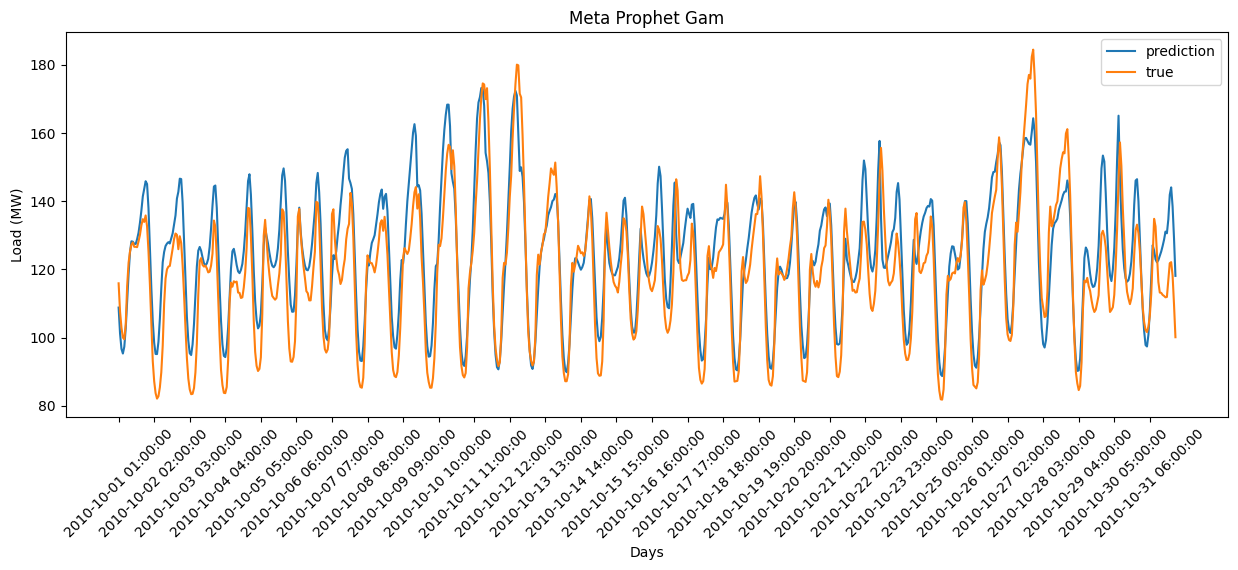

In [46]:

plt.figure(figsize=(15,5))
# plt.plot(y_hat, label="prediction")
plt.plot(np.exp(y_hat), label="prediction")
plt.plot(df_test["DS"],y_test, label="true")

plt.xticks(np.arange(0,len(y_test)+1,25),rotation=45)

plt.xlabel("Days")
plt.ylabel("Load (MW)")
plt.title("Meta Prophet Gam")
plt.legend()
plt.show()

Error metric

In [45]:
# we need to exponentiate because we applied log when passing it as independent variable
# np.sqrt(mean_squared_error(y_test, y_hat))
np.sqrt(mean_squared_error(y_test, np.exp(y_hat)))

10.29362806230159

Prophet_v2 Additional plots

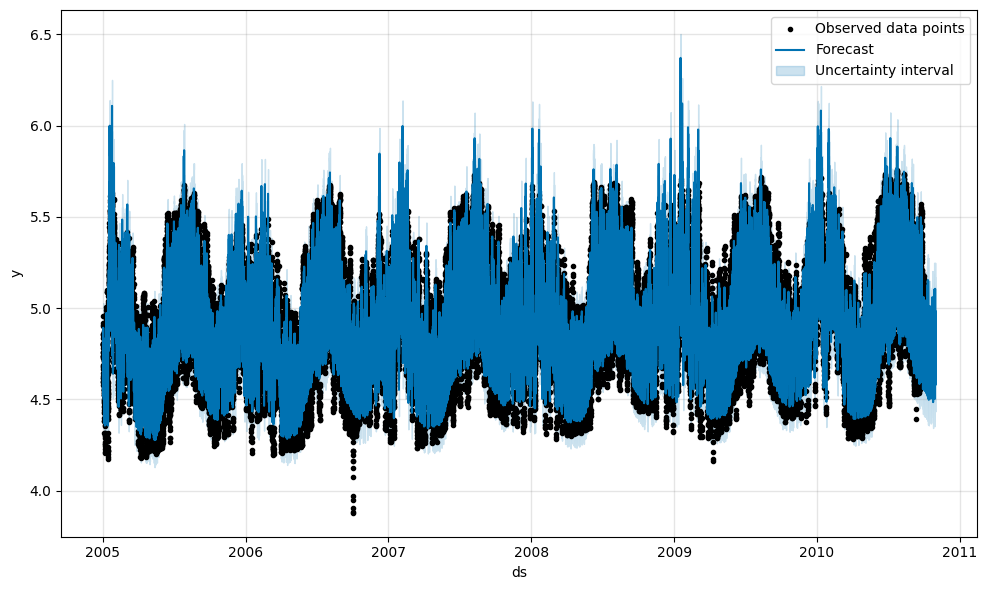

In [637]:
prophet.plot(forecast, ax=None, uncertainty=True, plot_cap=True,xlabel='ds', ylabel='y', figsize=(10, 6), include_legend=True)
plt.show()

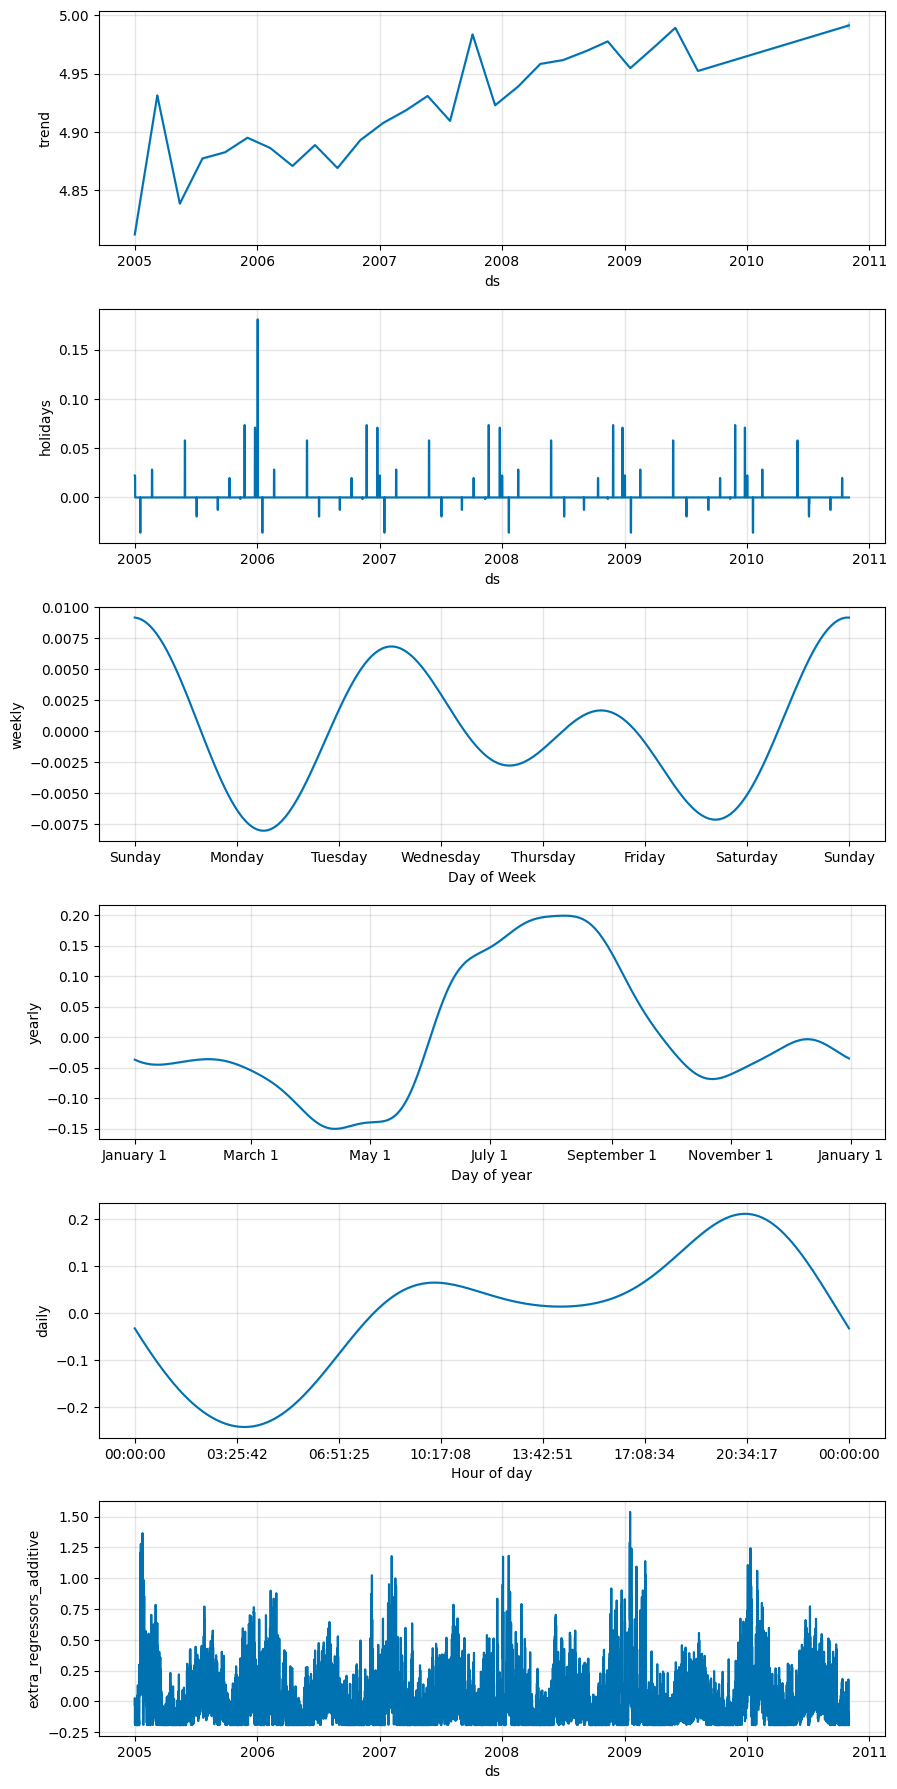

In [639]:
prophet.plot_components(forecast)
plt.show()

Save model

In [18]:
# pickle.dump(prophet, open("/Users/luca/Desktop/ThesisKernelMethods/experiments/point/models/prophet_v3_load.pkl", "wb"))

prophet_v2=pickle.load(open("/Users/luca/Desktop/ThesisKernelMethods/experiments/point/models/prophet_v2_load.pkl", "rb"))

In [19]:
proph=pickle.load(open("/Users/luca/Desktop/ThesisKernelMethods/experiments/point/models/prophet_v2_load.pkl", "rb"))